In [1]:
# Import libs
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import keras
import random
from sklearn.model_selection import train_test_split
from keras.datasets import fashion_mnist
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, BatchNormalization, MaxPool2D, Conv2DTranspose, Reshape, Concatenate, Embedding
from keras.layers.advanced_activations import LeakyReLU
from keras.initializers import RandomNormal
from tqdm import tqdm_notebook

###1. Dùng GAN sinh ảnh trong dữ liệu fashion-MNIST

In [ ]:
# load datasets
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=10_000)
print('Train size: \t', x_train.shape[0])
print('Valid size: \t', x_val.shape[0])
print('Test size: \t', x_test.shape[0])

4431872/4422102 [==============================] - 0s 0us/step
Train size: 	 50000
Valid size: 	 10000
Test size: 	 10000


In [ ]:
# Data shape
print('Data shape: ', x_train[0].shape)

Data shape:  (28, 28)


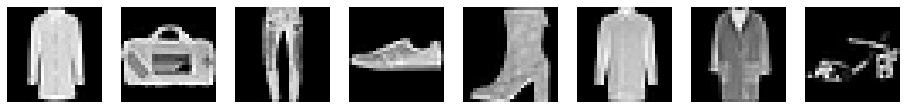

In [ ]:
# plot some samples
plt.figure(figsize=(16, 8))
for i in range(8):
  plt.subplot(1, 8, i+1)
  plt.axis('off')
  plt.imshow(x_train[i], cmap='gray')

plt.show()

In [ ]:
# vectorize input
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)
x_val = x_val.reshape(-1, 784)

# normalize
x_train = x_train / 255.
x_test = x_test / 255.
x_val = x_val / 255.

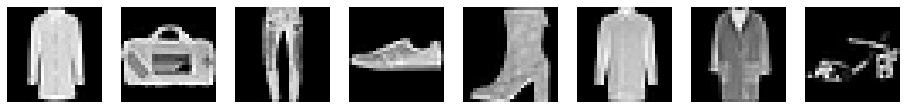

In [ ]:
# plot some samples after preprocessing
plt.figure(figsize=(16, 8))
for i in range(8):
  plt.subplot(1, 8, i+1)
  plt.axis('off')
  plt.imshow(x_train[i].reshape(28, 28), cmap='gray')

plt.show()

In [ ]:
# noise vector
z_dim = 128

In [ ]:
# define model
# optimizer
adam = Adam(learning_rate=0.0002, beta_1=0.5)

# define a CNN generator
def GeneratorBuilder(z_dim = 128):
  act = LeakyReLU(alpha=0.2)

  G = Sequential()
  G.add(Dense(256, input_dim=z_dim, activation=act))
  G.add(Dense(512, activation=act))
  G.add(Dense(1024, activation=act))
  G.add(Dense(784, activation='sigmoid')) # normalize output

  G.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

  return G

In [ ]:
G = GeneratorBuilder(z_dim)
G.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_7 (Dense)              (None, 784)               803600    
Total params: 1,493,520
Trainable params: 1,493,520
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# define a CNN discriminator
def DiscriminatorBuilder():
  act = LeakyReLU(alpha=0.2)

  D = Sequential()

  D.add(Dense(1024, activation=act, input_dim=784))
  D.add(Dense(512, activation=act))
  D.add(Dense(256, activation=act))
  D.add(Dense(1, activation='sigmoid'))

  D.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
  
  return D

In [ ]:
D = DiscriminatorBuilder()
D.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 1024)              803840    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total params: 1,460,225
Trainable params: 1,460,225
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Define GAN model
D.trainable = False
inputs = Input(shape=(z_dim,))
hidden = G(inputs)
output = D(hidden)
gan = Model(inputs, output, name='GAN')
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
gan.summary()

Model: "GAN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1493520   
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 1460225   
Total params: 2,953,745
Trainable params: 1,493,520
Non-trainable params: 1,460,225
_________________________________________________________________


In [ ]:
# show loss
def visualize_loss(losses):
  d_loss = [v[0] for v in losses['D']]
  g_loss = [v[0] for v in losses['G']]
  plt.figure(figsize=(10, 8))
  plt.plot(d_loss, label='Discriminator loss')
  plt.plot(g_loss, label='Generator loss')

  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [ ]:
# plot samples generated from Generator
def visualize_generator(n_ex=10, dim=(1, 10), figsize=(12, 2)):
  noise=np.random.normal(0, 1, size=(n_ex, z_dim))
  generated_image = G.predict(noise)
  generated_image = generated_image.reshape(n_ex, 28, 28)

  plt.figure(figsize=figsize)
  for i in range(n_ex):
    plt.subplot(dim[0], dim[1], i + 1)
    plt.imshow(generated_image[i], interpolation='nearest', cmap='gray')
    plt.axis('off')

  plt.tight_layout()
  plt.show()

In [ ]:
losses = { 'D':[], 'G':[]}

def train(epochs=1, plot_frequency=1, batch_size=128):
  n_batches = x_train.shape[0] // batch_size
  print('Epochs: \t\t', epochs)
  print('Batch size: \t\t', batch_size)
  print('Number of batch: \t', n_batches)

  for e in tqdm_notebook(range(1, epochs + 1)):
    # header
    if e == 1 or e % plot_frequency == 0:
      print('-'*10, 'Epoch %d' %e, '-'*10)
    
    for _ in range(n_batches):
      # take random samples from trainning set
      image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

      # create noise
      noise = np.random.normal(0, 1, size=(batch_size, z_dim))

      # create samples using Generator
      generated_image = G.predict(noise)
      X = np.concatenate((image_batch, generated_image))

      # Create labels
      y = np.zeros(2 * batch_size)
      y[:batch_size] = 1

      # Train discriminator
      D.trainable = True
      d_loss = D.train_on_batch(X, y)

      # Train generator
      noise = np.random.normal(0, 1, size=(batch_size, z_dim))

      # try to lie discriminator by labeling all fake images with 1
      y2 = np.ones(batch_size)

      # train generator only
      D.trainable = False

      g_loss = gan.train_on_batch(noise, y2)

    losses['D'].append(d_loss)
    losses['G'].append(g_loss)

    # plot some samples
    if e == 1 or e % plot_frequency == 0:
      visualize_generator()
  visualize_loss(losses)

Epochs: 		 200
Batch size: 		 128
Number of batch: 	 390


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


---------- Epoch 1 ----------


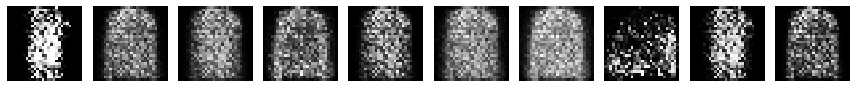

---------- Epoch 20 ----------


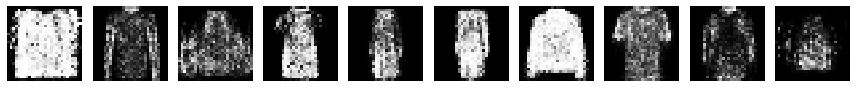

---------- Epoch 40 ----------


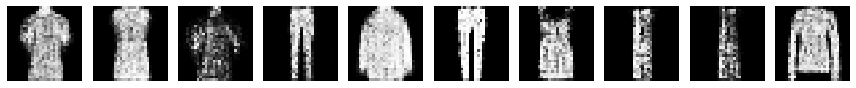

---------- Epoch 60 ----------


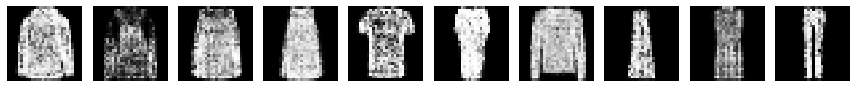

---------- Epoch 80 ----------


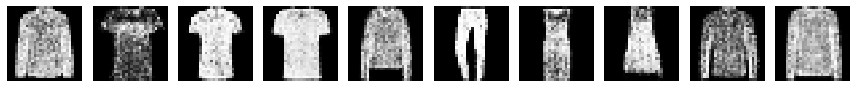

---------- Epoch 100 ----------


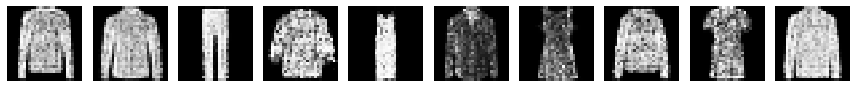

---------- Epoch 120 ----------


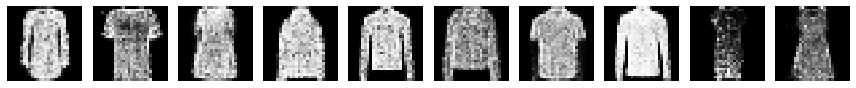

---------- Epoch 140 ----------


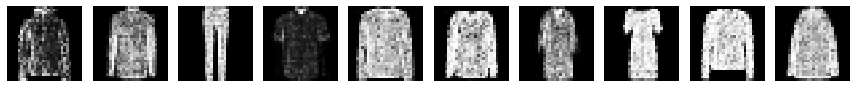

---------- Epoch 160 ----------


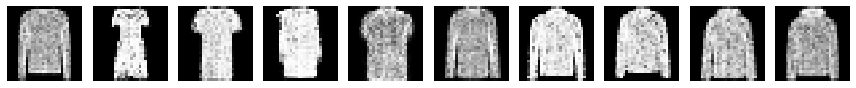

---------- Epoch 180 ----------


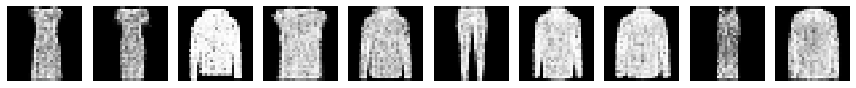

---------- Epoch 200 ----------


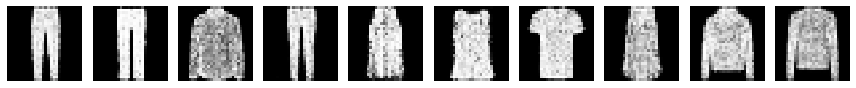

NameError: ignored

In [ ]:
train(epochs=200, plot_frequency=20, batch_size=128)

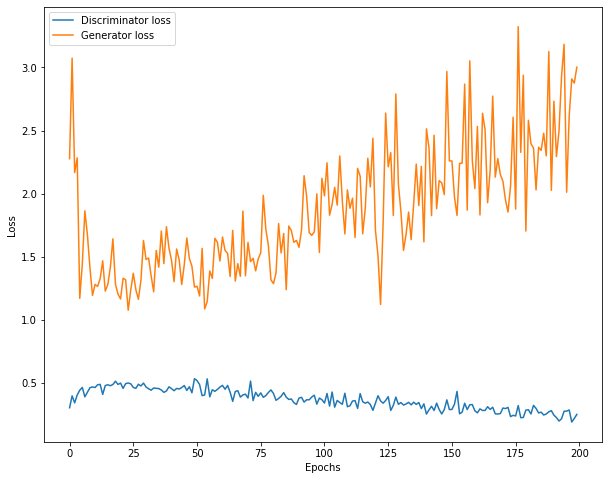

In [ ]:
visualize_loss(losses)

###2. Dùng cGAN (conditional GAN) sinh từng kiểu dữ liệu trong fashion-MNIST

In [2]:
# define discriminator
def DiscriminatorBuilder(in_shape=(28, 28, 1), n_classes=10):
  # label input
  in_label = Input(shape=(1,))
  # embedding for categorical input
  li = Embedding(n_classes, 50)(in_label)
  # scale up to image dimensions
  n_nodes = in_shape[0] * in_shape[1]
  li = Dense(n_nodes)(li) # acivation = linear
  # reshape to additional channel
  li = Reshape((in_shape[0], in_shape[1], 1))(li)

  # image input
  in_image = Input(shape=in_shape)
  # concat label as a channel
  merge = Concatenate()([in_image, li])
  # downsample
  fe = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(merge)
  fe = LeakyReLU(0.2)(fe)

  # downsample
  fe = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(fe)
  fe = LeakyReLU(0.2)(fe)

  # Flatten feature maps
  fe = Flatten()(fe)

  # dropout
  fe = Dropout(0.4)(fe)

  # output
  out_layer = Dense(1, activation='sigmoid')(fe)

  # define model
  model = Model([in_image, in_label], out_layer)

  # compile model
  opt = Adam(0.0002, 0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  return model


In [3]:
# define generator
def GeneratorBuilder(latent_dim, n_classes=10):
  # Label input
  in_label = Input(shape=(1,))
  # embedding for categorical input
  li = Embedding(n_classes, 50)(in_label)
  # linear multiplication
  n_nodes = 7 * 7
  li = Dense(n_nodes)(li)
  # reshape to additional channel
  li = Reshape((7, 7, 1))(li)
  
  # image generator input
  in_lat = Input(shape=(latent_dim,))
  # foundation for 7*7 image
  n_nodes = 128 * 7 * 7
  gen = Dense(n_nodes)(in_lat)
  gen = LeakyReLU(0.2)(gen)
  gen = Reshape((7, 7, 128))(gen)
  # merge image gen and label input
  merge = Concatenate()([gen, li])

  # upsample to 14x14
  gen = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same')(merge)
  gen = LeakyReLU(0.2)(gen)

  # upsample to 28x28
  gen = Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same')(gen)
  gen = LeakyReLU(0.2)(gen)

  # output layer
  out_layer = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(gen)

  # define model
  model = Model([in_lat, in_label], out_layer)
  return model

In [4]:
# define gan
def GANBuilder(g_model, d_model):
  # make discriminator not trainable
  d_model.trainable = False
  # get noise and label output from generator model input
  gen_noise, gen_label = g_model.input
  # get image output from generator model
  gen_output = g_model.output
  # define gan output
  gan_output = d_model([gen_output, gen_label])
  # define model
  model = Model([gen_noise, gen_label], gan_output)
  # compile model
  opt = Adam(0.0002, 0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [5]:
# load real data
def load_real_sample():
  (x_train, y_train), (_, _) = fashion_mnist.load_data()
  X = expand_dims(x_train, axis=-1)
  # convert from int to float
  X = X.astype('float32')
  X = X / 255.
  return [X, y_train]

In [6]:
# select real samples
def generate_real_samples(dataset, n_samples):
  images, labels = dataset
  # choose random instances
  ix = np.random.randint(0, images.shape[0], n_samples)
  X, labels = images[ix], labels[ix]
  # generate class labels
  y = np.ones((n_samples, 1))
  return [X, labels], y

In [7]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
  # generate points in the latent space
  x_input = np.random.randn(latent_dim * n_samples)
  # rehshape into a batch of inputs
  z_input = x_input.reshape(n_samples, latent_dim)
  # generate labels
  labels = np.random.randint(0, n_classes, n_samples)
  return [z_input, labels]

In [8]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
  # generate point in latent space
  z_input, labels_input = generate_latent_points(latent_dim, n_samples)
  # predict output
  images = generator.predict([z_input, labels_input])
  # create class labels
  y = np.zeros((n_samples, 1))
  return [images, labels_input], y

In [9]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, batch_size=128):
  bat_per_epoch = dataset[0].shape[0] // batch_size
  half_batch = batch_size // 2

  for i in range(n_epochs):
    for j in range(bat_per_epoch):
      # get randomm selected real samples
      [x_real, labels_real], y_real = generate_real_samples(dataset, half_batch)

      # update discriminator model weights
      d_loss1, _ = d_model.train_on_batch([x_real, labels_real], y_real)

      # generate fake samples
      [x_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

      # update discriminator
      d_loss2, _ = d_model.train_on_batch([x_fake, labels_fake], y_fake)

      # prepare point in latent space as input for generator
      [z_input, labels_input] = generate_latent_points(latent_dim, batch_size)

      # create inverted labels for fake samples
      y_gan = np.ones((batch_size, 1))

      # update generator via discriminator's error
      g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
      # summarize loss on this batch
      print('>%d: %d/%d -> d1 = %.3f, d2 = %.3f, g = %.3f' %(i+1, j+1, bat_per_epoch, d_loss1, d_loss2, g_loss))
      # save model
  g_model.save('cgan_generator.h5')

In [10]:
latent_dim = 100
d_model = DiscriminatorBuilder()
g_model = GeneratorBuilder(latent_dim)
gan_model = GANBuilder(g_model, d_model)
dataset = load_real_sample()

4431872/4422102 [==============================] - 0s 0us/step


In [11]:
train(g_model, d_model, gan_model, dataset, latent_dim)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
>90: 150/468 -> d1 = 0.637, d2 = 0.637, g = 0.749
>90: 151/468 -> d1 = 0.697, d2 = 0.705, g = 0.762
>90: 152/468 -> d1 = 0.666, d2 = 0.667, g = 0.797
>90: 153/468 -> d1 = 0.675, d2 = 0.672, g = 0.825
>90: 154/468 -> d1 = 0.652, d2 = 0.639, g = 0.834
>90: 155/468 -> d1 = 0.642, d2 = 0.617, g = 0.828
>90: 156/468 -> d1 = 0.678, d2 = 0.615, g = 0.789
>90: 157/468 -> d1 = 0.666, d2 = 0.672, g = 0.804
>90: 158/468 -> d1 = 0.649, d2 = 0.677, g = 0.791
>90: 159/468 -> d1 = 0.614, d2 = 0.689, g = 0.788
>90: 160/468 -> d1 = 0.597, d2 = 0.650, g = 0.744
>90: 161/468 -> d1 = 0.678, d2 = 0.658, g = 0.794
>90: 162/468 -> d1 = 0.606, d2 = 0.693, g = 0.784
>90: 163/468 -> d1 = 0.654, d2 = 0.640, g = 0.785
>90: 164/468 -> d1 = 0.638, d2 = 0.614, g = 0.847
>90: 165/468 -> d1 = 0.655, d2 = 0.625, g = 0.799
>90: 166/468 -> d1 = 0.660, d2 = 0.674, g = 0.859
>90: 167/468 -> d1 = 0.672, d2 = 0.685, g = 0.812
>90: 168/468 -> d1 = 0.650, d2 = 0.633, g =

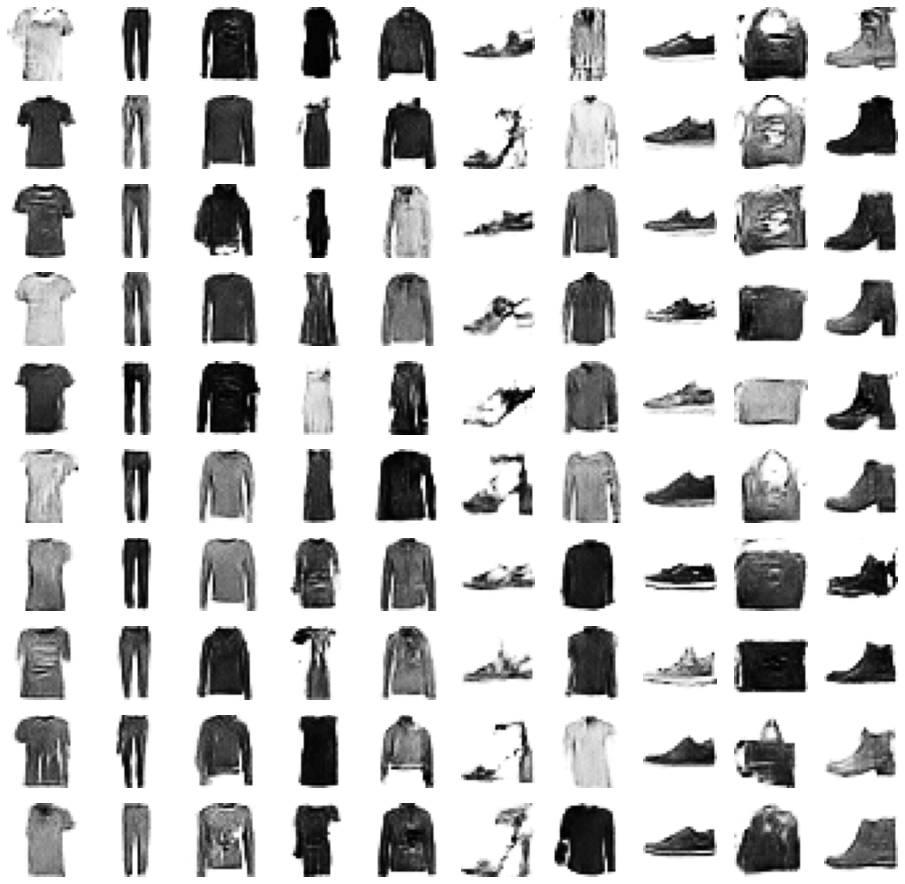

In [15]:
def save_plot(examples, n):
  # plot images
  plt.figure(figsize=(16, 16))
  for i in range(n * n):
    plt.subplot(n, n, i+1)
    plt.axis('off')
    plt.imshow(examples[i, :, :, 0], cmap='gray_r')
  plt.show()

model = keras.models.load_model('cgan_generator.h5')
# generate images
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = np.array([x for _ in range(10) for x in range(10)])
X = model.predict([latent_points, labels])
save_plot(X, 10)